In [1]:
from raspberry_listener.datatypes import Sensor, SensorData, SensorReading, SensorType
from raspberry_listener.remotereader import download_archive
from datetime import datetime
import pandera as pa
import pandera.typing as pat
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from dataclasses import dataclass
import polars as pl

In [2]:
archive = download_archive()
sensor_combinations = {"humidity": ["DHT11"], "temperature": ["DHT11","PI_CPU", "DS18B20"]}

In [3]:
df = pd.read_parquet(archive)
df = SensorData.repair_dataframe(df)

In [4]:
def make_max_mean_min_dataframe(
    df: pd.DataFrame, sensor_type: str, sensor: str
) -> pd.DataFrame:
    single_sensor_df: pd.DataFrame = df.loc[
        sensor_type, sensor
    ]  # Isolate the data of a single sensor

    def median_filter(df: pd.DataFrame) -> pd.DataFrame:
        return df.resample("10S").median(
            numeric_only=True
        )  # Apply a short median filter to the data to clean up any outliers. Optional

    def max_mean_min(df: pd.DataFrame) -> pd.DataFrame:
        '''Groups the data by hour, minute and second. This means the data for 14h:15m:48s for every day in the archive is grouped into a list, 
        and we look for the maximum value in the list, the mean, and the minimum value in the list. This is done for all 86400 seconds in the day.
        Any leap-second that might be in there would look like a second repeated itself, and just get grouped in with the previous second, which is fine.'''
        def get_recombined_index(df: pd.DataFrame):
            '''This recombines the hour-minute-second columns into a single, 1 day long datetime index suitable for plotting. 
            The day, month year etc is inferred as 1900.01.01, or maybe 1970.01.01. The day should be removed from the plot as it's a hallucination of the dataformat'''
            return pd.to_datetime(
                df.index.get_level_values(0).astype(str)
                + ","
                + df.index.get_level_values(1).astype(str)
                + ","
                + df.index.get_level_values(2).astype(str),
                format="%H,%M,%S",
            )
        

        time_col = df["timestamp"]
        grouping = [time_col.dt.hour, time_col.dt.minute, time_col.dt.second]
        grouper = df.groupby(grouping, as_index=False)
        df = grouper.agg(["max", "mean", "min"])
        def simplify_dataframe(df: pd.DataFrame) -> pd.DataFrame:
            '''Clean up the index and columns in the dataframe after the processing'''
            df = df.set_index(get_recombined_index(df)) # Set index back to regular datetime-index
            df = df.drop("timestamp", axis=1) # Get rid of the hour-min-second grouping columns
            df = df["reading"] # Reading is a multilevel column, with min, mean and max on the lower level. Flatten it out to just the lower level
            return df
        df = simplify_dataframe(df)
        return df

    return (
        single_sensor_df.pipe(median_filter).reset_index().pipe(max_mean_min)
    )

In [5]:
def plot_min_max(df: pd.DataFrame, sensor_type: str, sensor: str):
    max_min_df = make_max_mean_min_dataframe(df, sensor_type, sensor)
    max_min_df.plot(title=f"{sensor_type}, {sensor}")
    

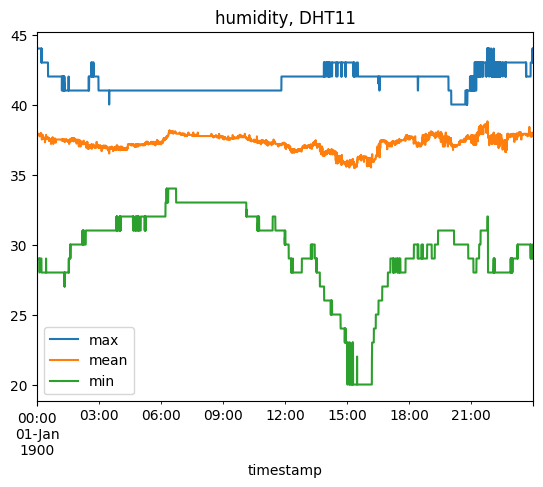

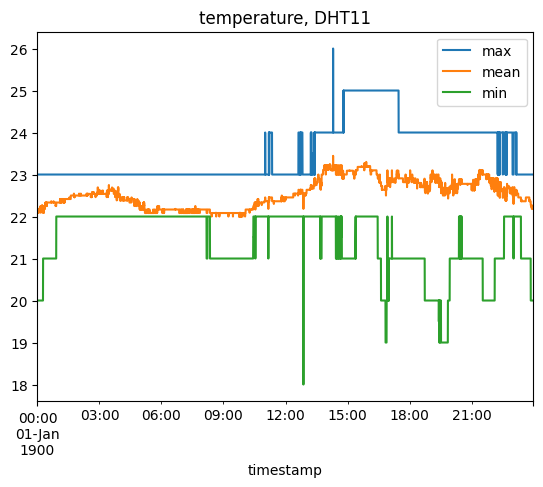

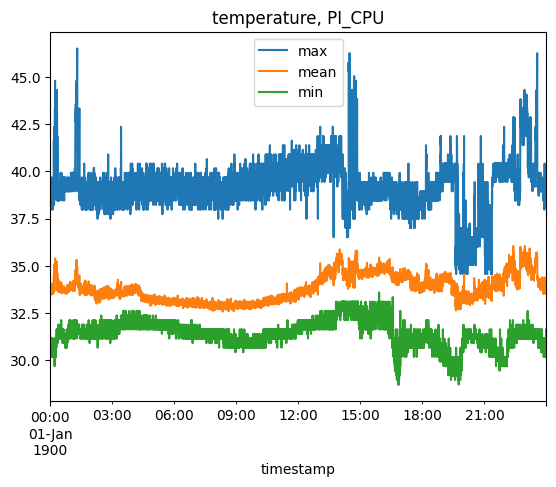

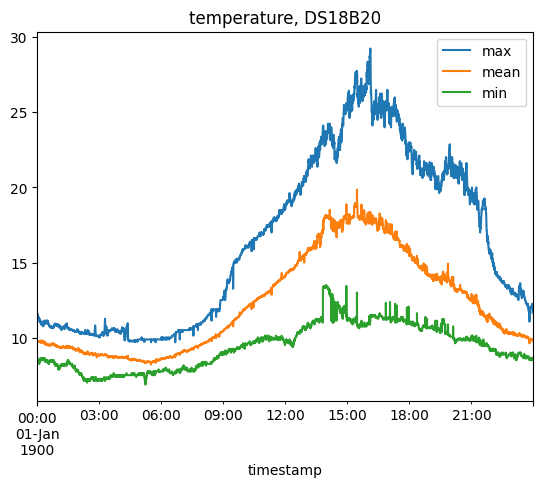

         822292 function calls (810964 primitive calls) in 0.750 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   103792    0.118    0.000    0.124    0.000 period.py:356(freq)
       32    0.076    0.002    0.076    0.002 {pandas._libs.tslibs.period.get_period_field_arr}
       36    0.066    0.002    0.067    0.002 base.py:2205(is_unique)
        4    0.039    0.010    0.039    0.010 {pandas._libs.tslibs.strptime.array_strptime}
        4    0.035    0.009    0.035    0.009 {pandas._libs.groupby.group_median_float64}
   103680    0.033    0.000    0.033    0.000 {built-in method _from_ordinal}
   103680    0.027    0.000    0.183    0.000 period.py:540(_box_func)
       12    0.022    0.002    0.022    0.002 {pandas._libs.tslibs.fields.get_date_field}
       44    0.018    0.000    0.018    0.000 {method 'take' of 'numpy.ndarray' objects}
       12    0.016    0.001    0.016    0.001 {built-in method pandas._libs.lib.en

In [9]:
def plot_all():
    for sensor_type, sensors in sensor_combinations.items():
        for sensor in sensors:
            plot_min_max(df, sensor_type, sensor)
%prun plot_all()